In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Predicting the Sale Price of Bulldozers using Machine Learning 🚜
In this notebook, we're going to go through an example machine learning project to use the characteristics of bulldozers and their past sales prices to predict the sale price of future bulldozers based on their characteristics.

Inputs: Bulldozer characteristics such as make year, base model, model series, state of sale (e.g. which US state was it sold in), drive system and more.
Outputs: Bulldozer sale price (in USD).
Since we're trying to predict a number, this kind of problem is known as a regression problem.

And since we're going to predicting results with a time component (predicting future sales based on past sales), this is also known as a time series or forecasting problem.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the Kaggle Bluebook for Bulldozers competition.

The techniques used in here have been inspired and adapted from the fast.ai machine learning course.


### Problem Definition
For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

### Data
Looking at the dataset from Kaggle we see that it contains historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:

Train.csv - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the target variable).
Valid.csv - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as Train.csv).
Test.csv - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the SalePrice attribute, as this is what we'll be trying to predict).
Note: You can download the dataset bluebook-for-bulldozers dataset directly from Kaggle. Alternatively, you can also download it directly from the course GitHub.

### Evaluation
For this problem, Kaggle has set the evaluation metric to being root mean squared log error (RMSLE). As with many regression evaluations, the goal will be to get this value as low as possible (a low error value means our model's predictions are close to what the real values are).

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the Kaggle leaderboard.

### Features
Features are different parts and attributes of the data.

During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this is to create a data dictionary.

For this dataset, Kaggle provides a data dictionary which contains information about what each attribute of the dataset means.

For example:

Variable Name	Description	Variable Type
SalesID	unique identifier of a particular sale of a machine at auction	Independent variable
MachineID	identifier for a particular machine; machines may have multiple sales	Independent variable
ModelID	identifier for a unique machine model (i.e. fiModelDesc)	Independent variable
datasource	source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs.	Independent variable
auctioneerID	identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource.	Independent variable
YearMade	year of manufacturer of the Machine	Independent variable
MachineHoursCurrentMeter	current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale	Independent variable
UsageBand	value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has fewer hours given its lifespan relative to the average of fiBaseModel.	Independent variable
Saledate	time of sale	Independent variable
fiModelDesc	Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor	Independent variable
State	US State in which sale occurred	Independent variable
Drive_System	machine configuration; typically describes whether 2 or 4 wheel drive	Independent variable
Enclosure	machine configuration - does the machine have an enclosed cab or not	Independent variable
Forks	machine configuration - attachment used for lifting	Independent variable
Pad_Type	machine configuration - type of treads a crawler machine uses	Independent variable
Ride_Control	machine configuration - optional feature on loaders to make the ride smoother	Independent variable
Transmission	machine configuration - describes type of transmission; typically automatic or manual	Independent variable
...	...	...
SalePrice	cost of sale in USD	Target/dependent variable
You can download the full version of this file directly from the Kaggle competition page (Kaggle account required) or view it on Google

In [2]:
df_tmp=pd.read_csv("TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [3]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_tmp.tail()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,2012-03-07,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412697,6333349,13000.0,1944743,21436,149,2.0,2006,NaN,NaN,2012-01-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [5]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [6]:
 df_tmp.sort_values(by=["saledate"],ascending=True,inplace=True)

In [7]:
df_tmp["saledate"]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
410879   2012-04-28
412476   2012-04-28
411927   2012-04-28
407124   2012-04-28
409203   2012-04-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [8]:
df=df_tmp.copy()

In [9]:
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,...,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00


In [11]:
df["saleYear"]=df["saledate"].dt.year
df["saleDay"]=df["saledate"].dt.day
df["saleMonth"]=df["saledate"].dt.month

In [12]:
df.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,...,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00


In [13]:
df.drop(columns=['SalesID'],inplace=True)

In [14]:
df.columns

Index(['SalePrice', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleDay',
       'saleMonth'],
      dtype='object')

In [15]:
df["state"].value_counts().sort_values(ascending=True)

state
Washington DC         2
Puerto Rico          42
Rhode Island         83
Hawaii              118
South Dakota        244
Vermont             300
Massachusetts       347
Alaska              430
North Dakota        480
Delaware            510
Kansas              667
West Virginia       840
Nebraska            866
Oklahoma           1326
Montana            1336
Iowa               1336
Wyoming            1672
Michigan           1831
Oregon             1911
Idaho              2025
Virginia           2353
New Hampshire      2738
Wisconsin          2745
Unspecified        2801
Utah               3046
New Mexico         3631
Arkansas           3933
Indiana            4124
Maine              5096
Kentucky           5351
Louisiana          6627
Nevada             6932
Missouri           7178
Minnesota          7885
Connecticut        8276
New York           8639
Arizona            9364
South Carolina     9951
Pennsylvania      10234
Alabama           10292
Tennessee         10298
North Caro

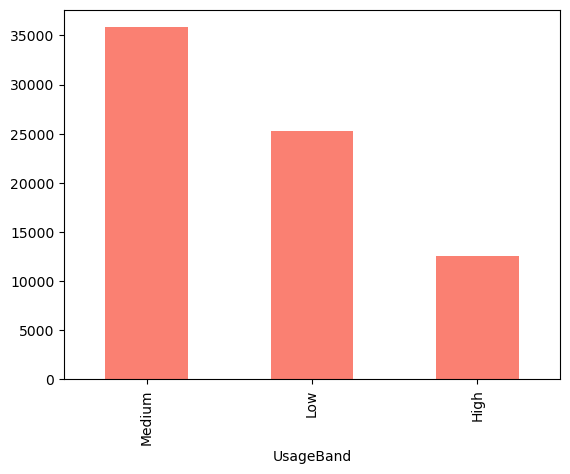

In [16]:
df["UsageBand"].value_counts().plot(kind='bar',color=['salmon']);
plt.show()

In [17]:
df.shape

(412698, 55)

In [18]:
df.isnull().sum()

SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [19]:
y=df["SalePrice"]

In [20]:
X=df.drop(columns=["SalePrice"])

In [21]:
X

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleDay,saleMonth
205615,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,TD20,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,17,1
274835,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,A66,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
141296,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,D7G,D7,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,31,1
212552,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,A62,A62,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
62755,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,D3B,D3,...,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,D38E,D38,...,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,28,4
412476,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,2064,2064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4
411927,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,337G,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4
407124,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,12G,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4


In [22]:
cat=[]
num=[]
for i in X.columns:
    if X[i].dtype=='O':
        cat.append(i)
    else:
        num.append(i)
    

In [23]:
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [24]:
num

['MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saledate',
 'saleYear',
 'saleDay',
 'saleMonth']

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalePrice                 412698 non-null  float64       
 1   MachineID                 412698 non-null  int64         
 2   ModelID                   412698 non-null  int64         
 3   datasource                412698 non-null  int64         
 4   auctioneerID              392562 non-null  float64       
 5   YearMade                  412698 non-null  int64         
 6   MachineHoursCurrentMeter  147504 non-null  float64       
 7   UsageBand                 73670 non-null   object        
 8   saledate                  412698 non-null  datetime64[ns]
 9   fiModelDesc               412698 non-null  object        
 10  fiBaseModel               412698 non-null  object        
 11  fiSecondaryDesc           271971 non-null  object        
 12  fi

In [26]:
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

### Convert Strings to Categories

In [27]:
pd.api.types.is_object_dtype(df_tmp['UsageBand'])

True

In [28]:
df.dtypes

SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type                            object
Ride_Contro

In [29]:
for label,content in df.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [30]:
for label,content in df.items():
    if pd.api.types.is_object_dtype(content):
        df[label]=content.astype('category').cat.as_ordered()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalePrice                 412698 non-null  float64       
 1   MachineID                 412698 non-null  int64         
 2   ModelID                   412698 non-null  int64         
 3   datasource                412698 non-null  int64         
 4   auctioneerID              392562 non-null  float64       
 5   YearMade                  412698 non-null  int64         
 6   MachineHoursCurrentMeter  147504 non-null  float64       
 7   UsageBand                 73670 non-null   category      
 8   saledate                  412698 non-null  datetime64[ns]
 9   fiModelDesc               412698 non-null  category      
 10  fiBaseModel               412698 non-null  category      
 11  fiSecondaryDesc           271971 non-null  category      
 12  fi

In [32]:
df["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [33]:
df["state"].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [34]:
df["state"].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [35]:
df["state"]

205615         Texas
274835       Florida
141296       Florida
212552       Florida
62755        Florida
             ...    
410879    California
412476    California
411927    California
407124    California
409203    California
Name: state, Length: 412698, dtype: category
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [36]:
df.isnull().sum()/len(df)

SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [37]:
### Save Proccessed Data

In [38]:
df.to_csv('train.csv',index=True)

In [39]:
df=pd.read_csv("train.csv",low_memory=False).reset_index(drop=True)

In [40]:
df

,Unnamed: 0,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleDay,saleMonth
0,205615,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,17,1
1,274835,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
2,141296,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,31,1
3,212552,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
4,62755,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,410879,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,28,4
412694,412476,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4
412695,411927,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4
412696,407124,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,28,4


In [41]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [42]:
df.head()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleDay,saleMonth
0,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,17,1
1,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
2,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,D7G,...,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,31,1
3,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,A62,...,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,31,1
4,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,D3B,...,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,31,1


In [43]:
### Fill Missing Values

In [44]:
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleDay
saleMonth


In [45]:
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [46]:
df["auctioneerID"]=df["auctioneerID"].fillna(df["auctioneerID"].median())

In [47]:
df["MachineHoursCurrentMeter"]=df["MachineHoursCurrentMeter"].fillna(df["MachineHoursCurrentMeter"].median())

In [48]:
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Turning Categories into Numbers and Filling Missing Values

In [49]:
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label+"_is_missing"]=pd.isnull(content)
        df[label]=pd.Categorical(content).codes+1
        

In [50]:
df.isnull().sum()

SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 100, dtype: int64

In [51]:
y

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
410879    16000.0
412476     6000.0
411927    16000.0
407124    55000.0
409203    34000.0
Name: SalePrice, Length: 412698, dtype: float64

In [52]:
len(df)

412698

In [53]:
df

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,9500.0,1126363,8434,132,18.0,1974,0.0,0,1,4593,...,True,True,True,True,True,False,False,False,True,True
1,14000.0,1194089,10150,132,99.0,1980,0.0,0,2,1820,...,True,True,True,True,True,True,True,True,False,False
2,50000.0,1473654,4139,132,99.0,1978,0.0,0,2,2348,...,True,True,True,True,True,False,False,False,True,True
3,16000.0,1327630,8591,132,99.0,1980,0.0,0,2,1819,...,True,True,True,True,True,True,True,True,False,False
4,22000.0,1336053,4089,132,99.0,1984,0.0,0,2,2119,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,16000.0,1915521,5266,149,99.0,2001,0.0,0,4013,2101,...,True,True,True,True,True,False,False,False,True,True
412694,6000.0,1919104,19330,149,99.0,2004,0.0,0,4013,240,...,True,True,True,True,True,True,True,True,True,True
412695,16000.0,1918416,17244,149,99.0,2004,0.0,0,4013,627,...,True,True,True,True,True,True,True,True,True,True
412696,55000.0,509560,3357,149,99.0,1993,0.0,0,4013,83,...,True,True,True,True,True,True,True,True,True,True


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [55]:
df.describe()

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleDay,saleMonth
count,412698.000000,4.126980e+05,412698.000000,412698.000000,412698.000000,412698.000000,4.126980e+05,412698.000000,412698.000000,412698.000000,...,412698.000000,412698.000000,412698.00000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000
mean,31215.181414,1.230061e+06,6947.201828,135.169361,6.361548,1899.049637,1.259165e+03,0.413486,2384.607885,1697.462231,...,0.517868,0.321254,0.19562,1.273566,1.126720,0.684513,0.345611,2004.317382,16.152894,6.300268
std,23141.743695,4.539533e+05,6280.824982,9.646749,16.763713,292.190243,1.633077e+04,0.941340,1061.162929,1281.860399,...,0.913654,0.662528,0.39680,2.644549,2.301722,1.503114,0.756225,5.821090,8.429510,3.437276
min,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1989.000000,1.000000,1.000000
25%,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,0.000000,1579.000000,640.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2000.000000,9.000000,3.000000
50%,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,0.000000,2576.000000,1413.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2006.000000,16.000000,6.000000
75%,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,0.000000e+00,0.000000,3241.000000,2316.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2009.000000,23.000000,9.000000
max,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,3.000000,4013.000000,5059.000000,...,3.000000,3.000000,2.00000,10.000000,7.000000,4.000000,5.000000,2012.000000,31.000000,12.000000


In [56]:
## Splitting the data into Train and valid

In [57]:
df["saleYear"].value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [58]:
df_train=df[df["saleYear"]!=2012]
df_val=df[df["saleYear"]==2012]

In [59]:
len(df_val)

11573

In [60]:
## splitting the data into variables

In [61]:
x_train=df_train.drop(columns=["SalePrice"])
y_train=df_train["SalePrice"]

In [62]:
x_train

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1126363,8434,132,18.0,1974,0.0,0,1,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1194089,10150,132,99.0,1980,0.0,0,2,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1473654,4139,132,99.0,1978,0.0,0,2,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1327630,8591,132,99.0,1980,0.0,0,2,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1336053,4089,132,99.0,1984,0.0,0,2,2119,683,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,1074871,4331,149,2.0,1000,0.0,0,3919,3137,1055,...,True,True,True,True,True,True,True,True,False,False
401121,1812622,9580,149,2.0,2005,0.0,0,3919,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401122,1811599,9580,149,2.0,2005,0.0,0,3919,4514,1684,...,True,True,True,True,True,True,True,True,True,True
401123,1858173,17432,149,2.0,2004,0.0,0,3919,3389,1175,...,True,True,True,True,True,True,True,True,True,True


In [63]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

In [64]:
df_val

,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
401125,46173.2,2318824,26964,173,99.0,1996,0.0,0,3920,2269,...,True,True,True,True,True,False,False,False,True,True
401126,66000.0,531393,23926,121,3.0,1000,8145.0,2,3921,85,...,True,True,True,True,True,True,True,True,True,True
401127,26800.0,1810917,13260,149,99.0,2000,24.0,2,3921,1115,...,True,True,True,True,True,True,True,True,True,True
401128,42100.0,1543404,1830,149,99.0,2004,4373.0,3,3921,64,...,False,False,False,False,False,True,True,True,True,True
401129,62100.0,1863077,11390,149,99.0,2006,3467.0,3,3921,139,...,False,False,False,False,False,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,16000.0,1915521,5266,149,99.0,2001,0.0,0,4013,2101,...,True,True,True,True,True,False,False,False,True,True
412694,6000.0,1919104,19330,149,99.0,2004,0.0,0,4013,240,...,True,True,True,True,True,True,True,True,True,True
412695,16000.0,1918416,17244,149,99.0,2004,0.0,0,4013,627,...,True,True,True,True,True,True,True,True,True,True
412696,55000.0,509560,3357,149,99.0,1993,0.0,0,4013,83,...,True,True,True,True,True,True,True,True,True,True


In [65]:
x_val=df_val.drop(columns=["SalePrice"])
y_val=df_val["SalePrice"]

In [66]:
x_val

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
401125,2318824,26964,173,99.0,1996,0.0,0,3920,2269,711,...,True,True,True,True,True,False,False,False,True,True
401126,531393,23926,121,3.0,1000,8145.0,2,3921,85,19,...,True,True,True,True,True,True,True,True,True,True
401127,1810917,13260,149,99.0,2000,24.0,2,3921,1115,328,...,True,True,True,True,True,True,True,True,True,True
401128,1543404,1830,149,99.0,2004,4373.0,3,3921,64,20,...,False,False,False,False,False,True,True,True,True,True
401129,1863077,11390,149,99.0,2006,3467.0,3,3921,139,41,...,False,False,False,False,False,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,1915521,5266,149,99.0,2001,0.0,0,4013,2101,690,...,True,True,True,True,True,False,False,False,True,True
412694,1919104,19330,149,99.0,2004,0.0,0,4013,240,84,...,True,True,True,True,True,True,True,True,True,True
412695,1918416,17244,149,99.0,2004,0.0,0,4013,627,203,...,True,True,True,True,True,True,True,True,True,True
412696,509560,3357,149,99.0,1993,0.0,0,4013,83,19,...,True,True,True,True,True,True,True,True,True,True


In [67]:
y_val=df_val["SalePrice"].reset_index(drop=True)

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [69]:
model=RandomForestRegressor(n_jobs=-1,
                             random_state=42)

In [70]:
model.fit(x_train[:10000],y_train[:10000])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [72]:
def evaluation(y_test,y_pred):
    print("MAE",mean_absolute_error(y_test,y_pred))
    print("MsE",mean_squared_error(y_test,y_pred))
    

In [73]:
model.score(x_train[:100],y_train[:100])

0.9918115948834058

In [74]:
model.score(x_val,y_val)

-0.2893648567334388

In [75]:
y_predt=model.predict(x_train[:10000])

In [76]:
### Training Evaluation
evaluation(y_train[:10000],y_predt)

MAE 1672.7171
MsE 6943194.2993


In [77]:
### Val Evaluation
y_predv=model.predict(x_val)

In [78]:
evaluation(y_val,y_predv)

MAE 23803.153866758836
MsE 885629151.62892


In [79]:
### The model Leads to overfitting so Tune the parameters

In [80]:
params= {
    'n_estimators': [100, 200, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [81]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=10,                
    cv=5,                                             
    scoring='r2',             
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [82]:
random_search.fit(x_train[:10000],y_train[:10000])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [83]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [116]:
df_test=pd.read_csv("Test.csv",parse_dates=["saledate"])

In [117]:
### Preprocessing on MY Test Data

In [118]:
df_test["saleYear"]=df_test["saledate"].dt.year
df_test["saleDay"]=df_test["saledate"].dt.day
df_test["saleMonth"]=df_test["saledate"].dt.month

In [119]:
for label,content in df_test.items():
    if pd.api.types.is_object_dtype(content):
        df_test[label]=content.astype('category').cat.as_ordered()

In [120]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   category      
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  category      
 10  fiBaseModel               12457 non-null  category      
 11  fiSecondaryDesc           8482 non-null   category      
 12  fiModelSeries     

In [121]:
for label,content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

MachineHoursCurrentMeter


In [122]:
df_test["MachineHoursCurrentMeter"]=df_test["MachineHoursCurrentMeter"].fillna(df_test["MachineHoursCurrentMeter"].median())

In [123]:
for label,content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_test[label+"_is_missing"]=pd.isnull(content)
        df_test[label]=pd.Categorical(content).codes+1

In [124]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 100, dtype: int64

In [126]:
id=df_test["SalesID"]

In [127]:
df_test.drop(columns=["SalesID"],inplace=True)

In [128]:
y_pred=model.predict(df_test)

In [129]:
y_pred

array([51130. , 14678.5, 76065. , ..., 28210. , 52482.5, 54525. ],
      shape=(12457,))

In [130]:
### This is one Of the Kaggale competetion Problem

In [131]:
submitted=pd.DataFrame()

In [132]:
submitted["SalesID"]=id
submitted["y_pred"]=y_pred

In [133]:
submitted

,SalesID,y_pred
0,1227829,51130.0
1,1227844,14678.5
2,1227847,76065.0
3,1227848,77252.5
4,1227863,32915.0
...,...,...
12452,6643171,49210.0
12453,6643173,49462.5
12454,6643184,28210.0
12455,6643186,52482.5


In [135]:
### Convert this into Csv and submit

In [136]:
submitted.to_csv('submitted.csv',index=False)